This jupyter notebook is here to test properties of the training set (positive-defineteness, symmetry, etc)

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
import numpy as np
import time, math, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

from CovNet import Network_Full, MatrixDataset, symmetric_log, symmetric_exp, matrix_loss

In [2]:
train_log = False
train_inverse = False
#N = 52500
N = 5000
training_dir = "/home/joeadamo/Research/Data/Training-Set/"
save_dir = "/home/joeadamo/Research/CovA-NN-Emulator/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

In [3]:
t1 = time.time()
data = MatrixDataset(training_dir, N, 0, train_log, train_inverse)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 1.97 s


In [5]:
non_positive_diag = []
non_symmetric = []
non_definete = []
t1 = time.time()

min_asym = 10000; max_asym = 0; avg_asym = 0.
# first test the base matrix
for i in range(N):
    C = data[i][1].detach().numpy()
    
    # test diagonal is all positives
    for i in range(C.shape[0]):
        if C[i,i] <= 0:
            non_positive_diag.append(i)
            break
    
    # test assymetry
    C_sym = 0.5*(C + C.T)
    C_asym = 0.5*(C - C.T)
    symmetric_val = np.linalg.norm(C_asym, 2) / np.linalg.norm(C_sym, 2)
    if abs(symmetric_val) > 1e-14: # this number should be 0 if the matrix is symmetric
        non_symmetric.append(i)
        min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
        avg_asym += symmetric_val
    
    # test eigenvalues are all positive
    eigen, v = np.linalg.eig(C)
    if np.all(eigen > 0.) == False:
        non_definete.append(i)
        
t2 = time.time()
print("Done! took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print(len(non_positive_diag), "Matrices have non-positive diagonals")
print(len(non_symmetric), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric)/N))
print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
print(len(non_definete), "Matrices don't have all positive eigenvalues")

Done! took 4 minutes 33.79 seconds
0 Matrices have non-positive diagonals
11200 (21.33%) Matrices are assymetric
min / max symmetric val: [1.000e-14, 5.899e-13] (avg = 5.135e-14
0 Matrices don't have all positive eigenvalues


In [5]:
# now test the inverse matrix

non_positive_diag_inv = []
non_symmetric_inv = []
non_definete_inv = []
min_asym = 10000; max_asym = 0; avg_asym = 0.
t1 = time.time()
for i in range(N):
    C = data[i][1].detach().numpy()
    P = np.linalg.inv(C)
    
    # test diagonal is all positives
    for i in range(C.shape[0]):
        if P[i,i] <= 0:
            non_positive_diag_inv.append(i)
            break
    
    # test assymetry
    P_sym = 0.5*(P + P.T)
    P_asym = 0.5*(P - P.T)
    symmetric_val = np.linalg.norm(P_asym, 2) / np.linalg.norm(P_sym, 2)
    if abs(symmetric_val) > 1e-14: # this number should be 0 if the matrix is symmetric
        non_symmetric_inv.append(i)
        min_asym = min(symmetric_val, min_asym); max_asym = max(symmetric_val, max_asym)
        avg_asym += symmetric_val
    
    # test eigenvalues are all positive
    eigen, v = np.linalg.eig(P)
    if np.all(eigen > 0.) == False:
        non_definete_inv.append(i)
        
t2 = time.time()
print("Done! took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print(len(non_positive_diag_inv), "Matrices have non-positive diagonals")
print(len(non_symmetric_inv), "({:0.2f}%) Matrices are assymetric".format(100.*len(non_symmetric_inv)/N))
print("min / max symmetric val: [{:0.3e}, {:0.3e}] (avg = {:0.3e}".format(min_asym, max_asym, avg_asym / len(non_symmetric)))
print(len(non_definete_inv), "Matrices don't have all positive eigenvalues")

KeyboardInterrupt: 

0


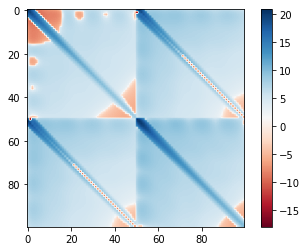

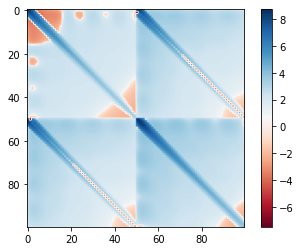

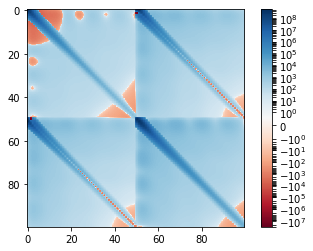

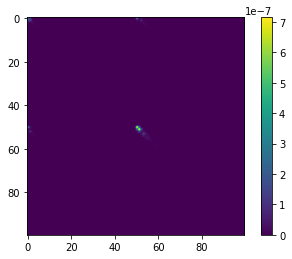

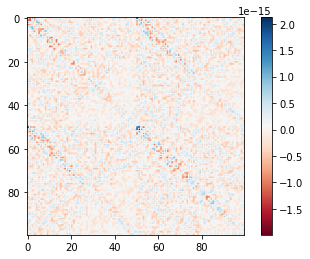

In [4]:
# test the logarithm function and make sure exp(log(C)) = C
idx = np.random.randint(0, N)
C = data[idx][1]
C_log = symmetric_log(C); C_1 = symmetric_exp(C_log)
# C and C_1 should be equal, so C - C_1 should just be a matrix of all zeros
idx_bad = np.where(abs((C - C_1) / C) > 1e-14)
print(len(idx_bad[0]))
# plt.imshow(C - C_1, cmap="RdBu")
# cbar = plt.colorbar()

C_sinh = np.arcsinh(C)
C_2 = np.sinh(C_sinh)
plt.figure()
plt.imshow(C_sinh, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
plt.imshow(C_log, cmap="RdBu")
cbar = plt.colorbar()

plt.figure()
m = plt.imshow(C_1, cmap="RdBu", norm=colors.SymLogNorm(linthresh=1.))
cbar = plt.colorbar()

plt.figure()
plt.imshow(abs(C_1 - C))
cbar = plt.colorbar()

plt.figure()
plt.imshow((C_1 - C) / C, cmap="RdBu")
cbar = plt.colorbar()

In [5]:
from CovNet import symmetric_log, symmetric_exp
x = np.linspace(-100, 100, 25)
x_log = symmetric_log(x)

m = x_log
pos_m, neg_m = np.zeros(m.shape), np.zeros(m.shape)
pos_idx = np.where(m >= 0)
neg_idx = np.where(m < 0)
pos_m[pos_idx] = m[pos_idx]
neg_m[neg_idx] = m[neg_idx]

pos_m = 10**pos_m - 1
pos_m[(pos_m == 1)] = 0
# for negative numbers, treat log(x) = -log(-x)
neg_m[neg_idx] = -10**(-1*neg_m[neg_idx]) + 1
m_1 = torch.from_numpy(pos_m + neg_m)

x_1 = symmetric_exp(x_log)
print(x)
print(x_log)
print(m_1)
print(x_1)

[-100.          -91.66666667  -83.33333333  -75.          -66.66666667
  -58.33333333  -50.          -41.66666667  -33.33333333  -25.
  -16.66666667   -8.33333333    0.            8.33333333   16.66666667
   25.           33.33333333   41.66666667   50.           58.33333333
   66.66666667   75.           83.33333333   91.66666667  100.        ]
tensor([-2.0043, -1.9669, -1.9260, -1.8808, -1.8304, -1.7733, -1.7076, -1.6301,
        -1.5357, -1.4150, -1.2472, -0.9700,  0.0000,  0.9700,  1.2472,  1.4150,
         1.5357,  1.6301,  1.7076,  1.7733,  1.8304,  1.8808,  1.9260,  1.9669,
         2.0043], dtype=torch.float64)
tensor([-100.0000,  -91.6667,  -83.3333,  -75.0000,  -66.6667,  -58.3333,
         -50.0000,  -41.6667,  -33.3333,  -25.0000,  -16.6667,   -8.3333,
           0.0000,    8.3333,   16.6667,   25.0000,   33.3333,   41.6667,
          50.0000,   58.3333,   66.6667,   75.0000,   83.3333,   91.6667,
         100.0000], dtype=torch.float64)
tensor([-100.0000,  -91.6667,  -83.3

In [28]:
# Convert data in .txt format to data in .npz format
training_dir = "/home/joeadamo/Research/Data/Training-Set/"
new_dir = "/home/joeadamo/Research/Data/Training-Set-New/"
for idx in range(52500):
    
    file = training_dir+"CovA-"+f'{idx:05d}'+".txt"
    f = open(file)
    header = f.readline()
    header = f.readline()
    f.close()
    header = torch.from_numpy(np.fromstring(header[2:-1], sep=","))
    params = torch.cat([header[0:4], header[5:]]).detach().numpy()
    # load in matrix
    C = np.loadtxt(file, skiprows=2)
    np.savez(new_dir+"CovA-"+f'{idx:05d}'+".npz", params=params, C=C)
    
    test = np.load(new_dir+"CovA-"+f'{idx:05d}'+".npz")
    params_l = test["params"]; C_l = test["C"]
    assert np.array_equal(params_l, params) and np.array_equal(C, C_l)
print("Done!")

Done!
